**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
data = pd.read_csv('/kaggle/input/electricity-prices/clean_data.csv') 
data.head() 

,year,month,stateDescription,sectorName,customers,price,revenue,sales
0,2001,1,Wyoming,all sectors,NaN,4.31,48.12840,1116.17208
1,2001,1,Wyoming,commercial,NaN,5.13,12.67978,247.08691
2,2001,1,Wyoming,industrial,NaN,3.26,19.60858,602.30484
3,2001,1,Wyoming,other,NaN,4.75,0.76868,16.17442
4,2001,1,Wyoming,residential,NaN,6.01,15.07136,250.60591


**Data Analysis**

In [3]:
data.describe()

,year,month,customers,price,revenue,sales
count,85870.000000,85870.000000,5.983000e+04,85870.000000,85870.000000,85870.000000
mean,2012.043321,6.480144,2.916013e+06,9.300193,586.627155,5980.048970
std,6.660304,3.461589,1.200567e+07,5.010382,2161.047702,21302.453181
min,2001.000000,1.000000,0.000000e+00,0.000000,-0.000010,0.000000
25%,2006.000000,3.000000,4.998000e+03,6.650000,29.475195,289.144572
50%,2012.000000,6.000000,2.997540e+05,8.840000,121.641500,1447.518085
75%,2018.000000,9.000000,2.028716e+06,11.380000,421.320628,4339.950965
max,2024.000000,12.000000,1.625050e+08,116.670000,52361.450970,391900.008970


In [4]:
data.shape

(85870, 8)

In [5]:
data.info

<bound method DataFrame.info of        year  month stateDescription      sectorName  customers  price  \
0      2001      1          Wyoming     all sectors        NaN   4.31   
1      2001      1          Wyoming      commercial        NaN   5.13   
2      2001      1          Wyoming      industrial        NaN   3.26   
3      2001      1          Wyoming           other        NaN   4.75   
4      2001      1          Wyoming     residential        NaN   6.01   
...     ...    ...              ...             ...        ...    ...   
85865  2024      1         Arkansas     all sectors  1717720.0   9.63   
85866  2024      1         Arkansas      commercial   208669.0  10.26   
85867  2024      1         Arkansas      industrial    34951.0   7.08   
85868  2024      1         Arkansas     residential  1474098.0  11.24   
85869  2024      1         Arkansas  transportation        2.0  12.70   

         revenue       sales  
0       48.12840  1116.17208  
1       12.67978   247.08691 

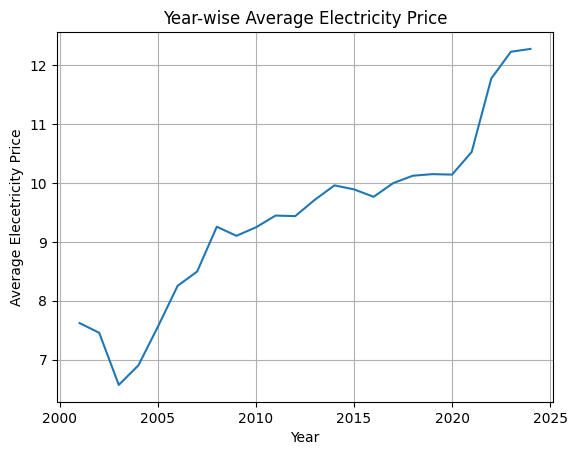

In [6]:
yearly_avg_price = data.groupby('year')['price'].mean().reset_index()
plt.plot(yearly_avg_price['year'],yearly_avg_price['price'])
plt.title('Year-wise Average Electricity Price')
plt.xlabel('Year')
plt.ylabel('Average Elecetricity Price')
plt.grid(True)
plt.show() 

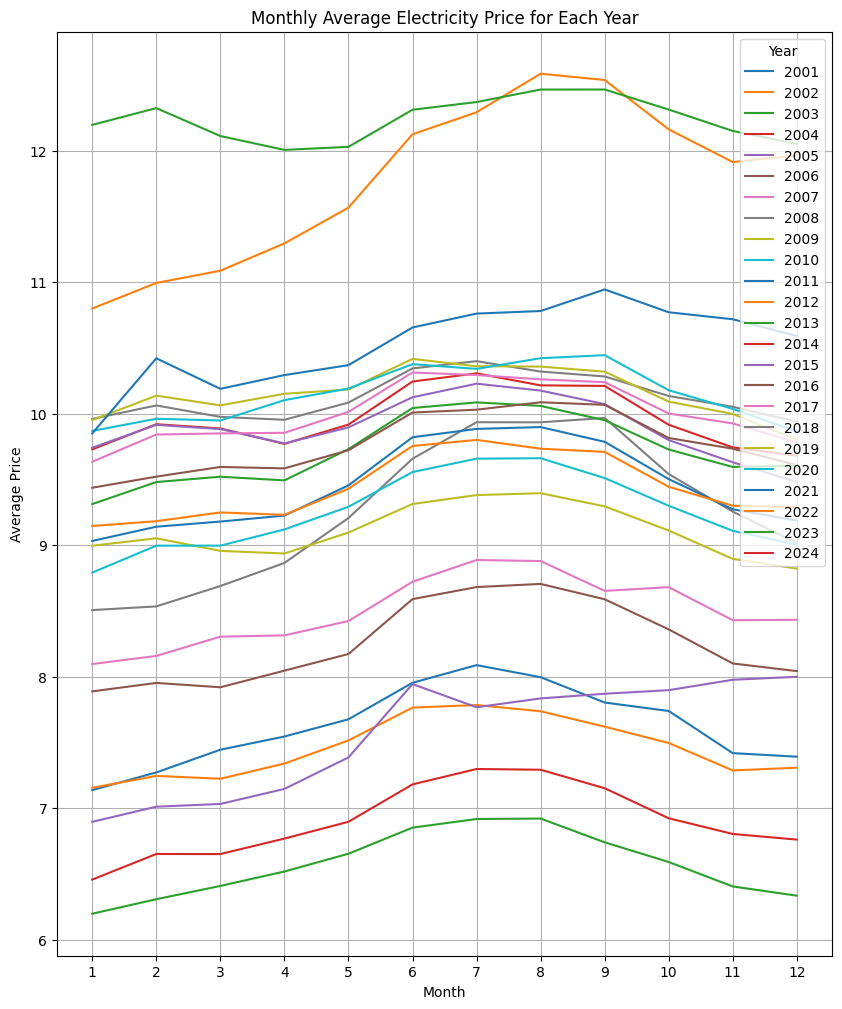

In [7]:
plt.figure(figsize=(10,12))
monthly_avg = data.groupby(['year','month'])['price'].mean().reset_index()
for year in monthly_avg['year'].unique():
    data_by_year = monthly_avg[monthly_avg['year'] == year]
    plt.plot(data_by_year['month'], data_by_year['price'], label=year)

plt.title('Monthly Average Electricity Price for Each Year')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.legend(title='Year')
plt.grid(True)
plt.xticks(range(1, 13))
plt.show() 

In [8]:
#increase in the average price observed during the 7th and 8th months
price_increse_in_6_7 = []
for year in data['year'].unique():
    data_year = data[data['year'] == year]
    monthly_avg = data_year.groupby('month')['price'].mean()
    avg_price_6_7 = data_year[data_year['month'].isin([6,7])]['price'].mean()
    avg_price_rest = data_year[~data_year['month'].isin([6,7])]['price'].mean()
    rate_of_increase = ((avg_price_6_7 - avg_price_rest) / avg_price_rest) * 100
    result = {
        'year':year,
        'rate_of_increase':rate_of_increase
    }
    price_increse_in_6_7.append(result)
price_increse_in_6_7_df = pd.DataFrame(price_increse_in_6_7)

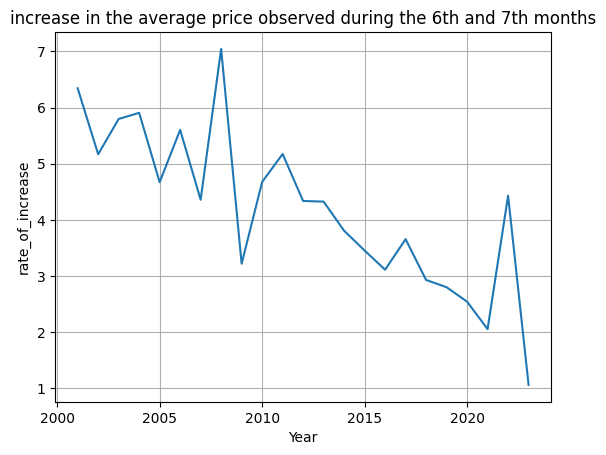

In [9]:
plt.plot(price_increse_in_6_7_df['year'],price_increse_in_6_7_df['rate_of_increase'])
plt.title('increase in the average price observed during the 6th and 7th months')
plt.xlabel('Year')
plt.ylabel('rate_of_increase')
plt.grid(True) 
plt.show() 

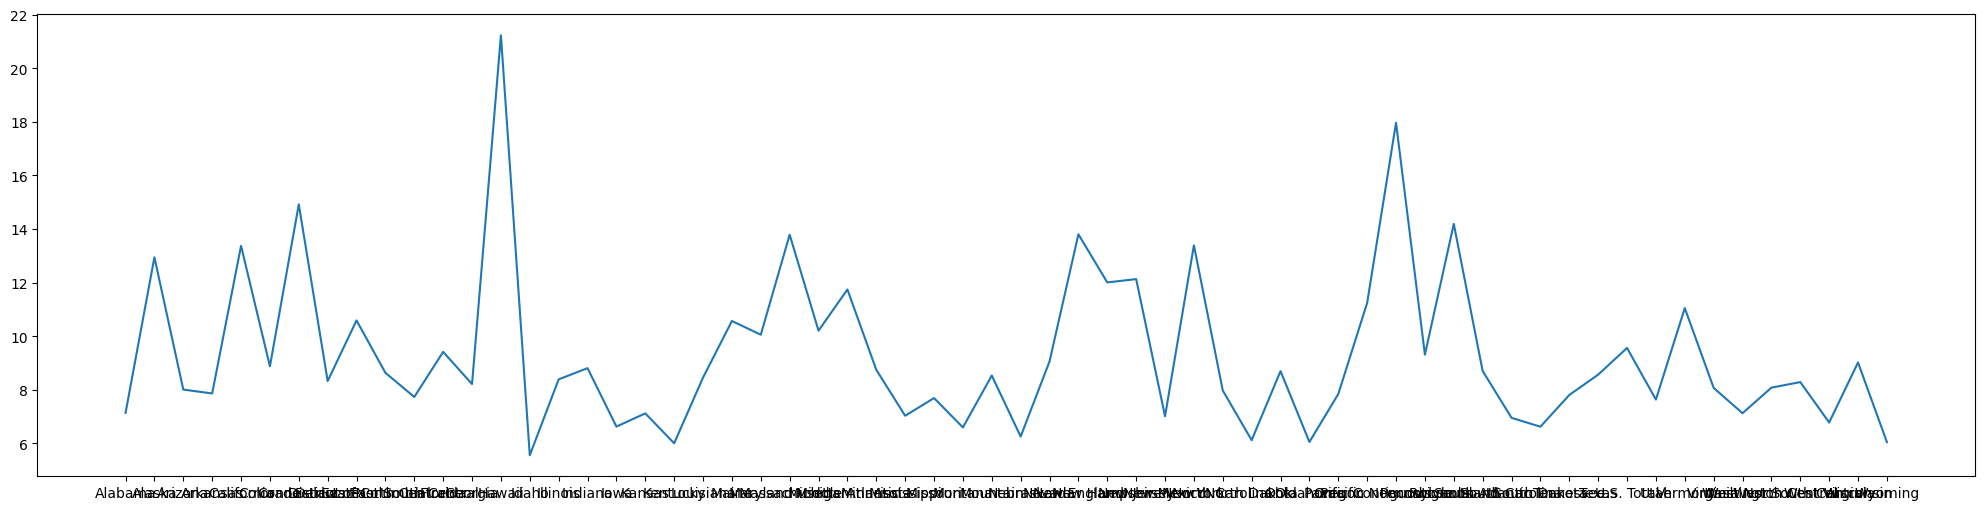

In [10]:
data_state = data.groupby('stateDescription')['price'].mean().reset_index()
plt.figure(figsize=(25,6))
plt.plot(data_state['stateDescription'],data_state['price'])  

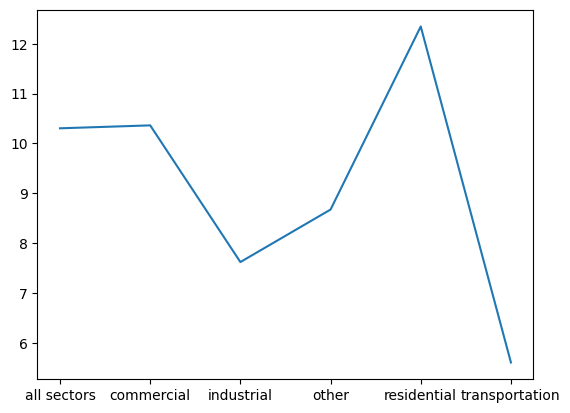

In [11]:
data_sector = data.groupby('sectorName')['price'].mean().reset_index()
plt.plot(data_sector['sectorName'],data_sector['price'])  

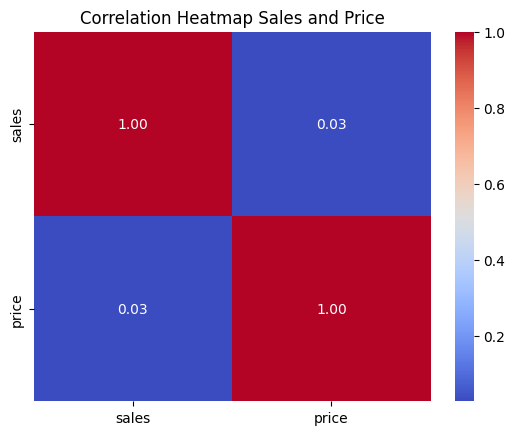

In [12]:
data_sales = data[['sales','price']]
corr_matrix_sales = data_sales.corr()
sns.heatmap(corr_matrix_sales, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap Sales and Price')
plt.show()

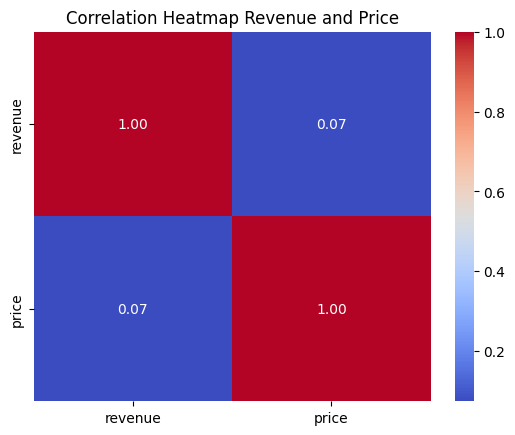

In [13]:
data_revenue = data[['revenue','price']]
corr_matrix_revenue = data_revenue.corr()
sns.heatmap(corr_matrix_revenue, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap Revenue and Price')
plt.show()

In [14]:
label_encoder = LabelEncoder()
data['sectorName'] = label_encoder.fit_transform(data['sectorName'])
data['stateDescription']= label_encoder.fit_transform(data['stateDescription'])
data.drop(['customers','revenue','sales'],axis=1,inplace= True)

In [15]:
X = data.drop(['price'],axis=1)
y=data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250]  # Adjust this range as needed
}
rf = RandomForestRegressor(random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

best_n_estimators = grid_search.best_params_['n_estimators']

best_rf = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
best_rf.fit(X, y)

y_pred = best_rf.predict(X)

mse = mean_squared_error(y, y_pred)
print("Best number of estimators:", best_n_estimators)
print("Mean Squared Error (MSE):", mse)

Best number of estimators: 100
Mean Squared Error (MSE): 0.08375476406859207
